In [235]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [236]:
from matplotlib import pyplot as plt
%matplotlib inline

In [237]:
from pathlib import Path
from imageio import imread, imsave
from skimage import transform
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# Check Hardware and Tools

In [4]:
import keras
import tensorflow as tf
keras.__version__, tf.__version__

('2.2.2', '1.3.0')

In [5]:
from tensorflow.python.client import device_lib
for d in device_lib.list_local_devices():
    print(d)

name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3788625669929834471

name: "/gpu:0"
device_type: "GPU"
memory_limit: 11332668621
locality {
  bus_id: 1
}
incarnation: 4568486989625669316
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0"



# Data Augmentation Setup

In [378]:
image_size = 64

In [64]:
data_path = Path('data/pca_img_gray/')
ds_paths = list(data_path.iterdir())
# ds_path = ds_paths[0]

In [65]:
def read_resize(img_path, mask=False):
    img = imread(img_path)
    img = transform.resize(img, (image_hw, image_hw), mode='constant')
    img = img / img.max()
    if mask: img = np.around(img)
    return img

In [275]:
class BatchGenerator(object):
    
    def __init__(self, data_path, pca_image_n=10):
        self.pca_image_n = pca_image_n
        self.data_path = Path(data_path)
        self.mean = None
        self.eps = 1e-6
        self.std = None
        
    def fit(self, X):
        self.mean = np.mean(X, axis=(0, 1, 2))
        self.std = np.std(X - self.mean, axis=(0, 1, 2))
    
    def normalize(self, X):
        return (X - self.mean) / (self.std + self.eps)
    
    def train_generator(self, ds_names, test=False,
                  batch_size=2, target_size=(64, 64), seed=13, aug_dict=None):
        X_list = []
        for ds_path in (self.data_path / 'image').iterdir():
            if ds_path.name in ds_names:
                for img_path in ds_path.iterdir():
                    img = read_resize(img_path, mask=False)
                    X_list.append(img)
        y_list = []
        for ds_path in (self.data_path / 'mask').iterdir():
            if ds_path.name in ds_names:
                mask = read_resize(ds_path / 'mask.png', mask=True)
                for _ in range(self.pca_image_n):
                    y_list.append(mask)
        
        X = np.stack(X_list)
        X = X.reshape(X.shape + (1,))
        y = np.stack(y_list)
        y = y.reshape(y.shape + (1,))
        print(X.shape, y.shape)

        image_datagen = ImageDataGenerator(**aug_dict)
        if not test:
            self.fit(X)
        mask_datagen = ImageDataGenerator(**aug_dict)
        
        image_generator = image_datagen.flow(
            X, None,
            batch_size=batch_size,
            seed=seed)
        mask_generator = mask_datagen.flow(
            y, None,
            batch_size=batch_size,
            seed=seed)
        for img, mask in zip(image_generator, mask_generator):
            yield img, mask
            
    def test_generator(self, ds_names, test=False):
        mask_data_path = Path(data_path) / 'mask'
        for ds_path in (Path(data_path) / 'image').iterdir():
            if ds_path.name in test_ds_names:
                images = []
                for img_path in ds_path.iterdir():
                    img = read_resize(img_path, mask=False)
                    img = img.reshape(img.shape + (1,))
                    images.append(img)
                image_batch = np.stack(images)
                image_batch = self.normalize(image_batch)
                    
                mask_path = mask_data_path / ds_path.name / 'mask.png'
                mask = read_resize(mask_path, mask=True)
                mask = mask.reshape(mask.shape + (1,))
                yield ds_path.name, image_batch, mask[:,:,0]

In [269]:
def extract_train_ds_names(ds_path, test_ds_names):
    ds_names = [ds_path.name for ds_path in (data_path/'mask').iterdir()]
    train_ds_names = [name for name in ds_names
                      if name not in test_ds_names]
    return train_ds_names

In [270]:
# batch_generator_factory = BatchGenerator('data/pca_img_gray/')

In [375]:
data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     zca_whitening=False,
                     rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.05,
                     zoom_range=0.05,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='nearest')
# train_gen = batch_generator_factory.train_generator(train_ds_names, test=False, aug_dict=data_gen_args)
# test_gen = batch_generator_factory.test_generator(test_ds_names, test=True)

In [377]:
image_datagen = ImageDataGenerator(**data_gen_args)

In [387]:
transform_parameters = image_datagen.get_random_transform((image_size, image_size), seed=13)
transform_parameters

{'brightness': None,
 'channel_shift_intensity': None,
 'flip_horizontal': 0,
 'flip_vertical': 0,
 'shear': 0.04657491980429998,
 'theta': 5.5540482114764025,
 'tx': -3.359472383553123,
 'ty': 4.1507652180655175,
 'zx': 1.0472601113904894,
 'zy': 0.9953449247417312}

In [395]:
X_list = []
for ds_path in Path('data/pca_img_gray/image/').iterdir():
#     if ds_path.name in ds_names:
    for img_path in ds_path.iterdir():
        img = read_resize(img_path, mask=False)
        X_list.append(img.reshape(img.shape + (1,)))
    break
X = np.stack(X_list)
X.shape

(10, 64, 64, 1)

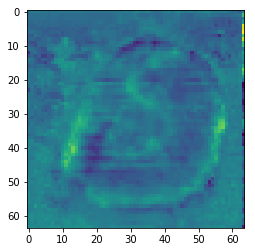

In [396]:
plt.imshow(X[0,:,:,0])

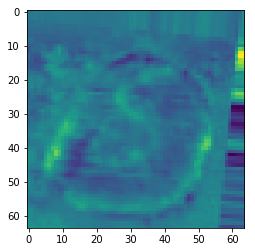

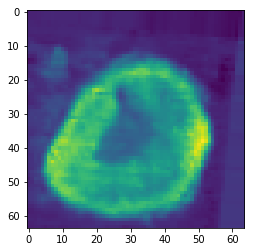

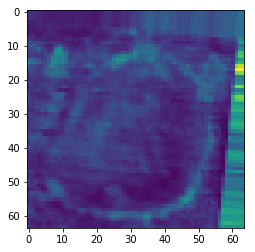

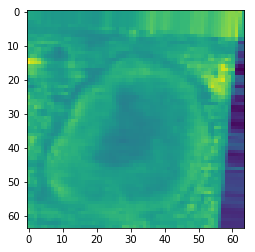

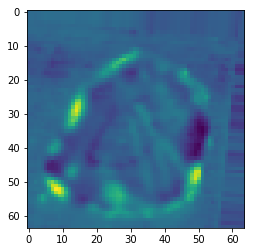

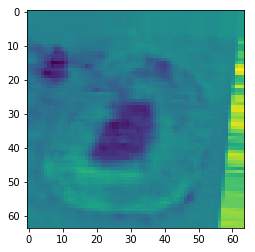

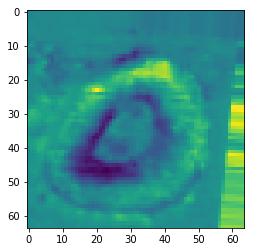

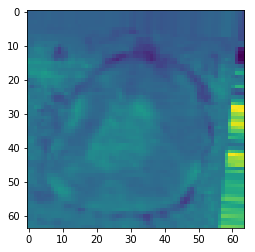

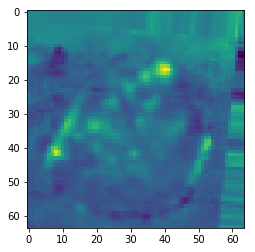

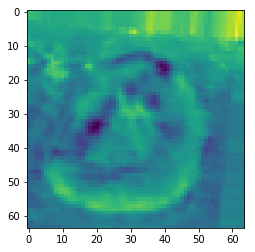

In [400]:
for i in range(10):
    img = image_datagen.apply_transform(X[i], transform_parameters)
    plt.imshow(img.squeeze())
    plt.show()

In [271]:
# img, mask = next(train_gen)
# img.shape, mask.shape
# plt.imshow(img[0,:,:,0])
# plt.show()
# plt.imshow(mask[0,:,:,0])
# plt.show()

In [272]:
# _, img, mask = next(test_gen)
# img.shape, mask.shape
# plt.imshow(img[1,:,:,0])
# plt.show()
# plt.imshow(mask[:,:])
# plt.show()

# Train U-Net

In [285]:
ds_path

PosixPath('data/pca_img_gray/image')

In [368]:
from unet.data import *
from unet.model import *

In [369]:
test_ds_names = [
    'adrenal gland neg',
    'ICL_A27 CT S4-centroid',
    'AstraZeneca_CT26_xenograft',
]
train_ds_names = extract_train_ds_names(ds_path, test_ds_names)
train_ds_names, test_ds_names

(['1000155A4+', '0800191A6+', 'Mousebrain_MG08_2017_GruppeF'],
 ['adrenal gland neg', 'ICL_A27 CT S4-centroid', 'AstraZeneca_CT26_xenograft'])

In [370]:
batch_generator_factory = BatchGenerator('data/pca_img_gray/')
data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     zca_whitening=False,
                     rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.05,
                     zoom_range=0.05,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='nearest')
train_gen = batch_generator_factory.train_generator(train_ds_names, batch_size=128, test=False,
                                                    aug_dict=data_gen_args)

In [371]:
# for i in range(10):
#     img, mask = next(train_gen)
#     f, (ax1, ax2) = plt.subplots(1, 2)
#     ax1.imshow(img[0,:,:,:])
#     ax2.imshow(mask[0,:,:,0])
#     plt.show()

In [373]:
# model = unet(input_size=(image_hw, image_hw, 3), summary=True)
model = unet(input_size=(image_hw, image_hw, 10))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 64, 64, 10)   0                                            
__________________________________________________________________________________________________
conv2d_467 (Conv2D)             (None, 64, 64, 8)    728         input_21[0][0]                   
__________________________________________________________________________________________________
conv2d_468 (Conv2D)             (None, 64, 64, 8)    584         conv2d_467[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_81 (MaxPooling2D) (None, 32, 32, 8)    0           conv2d_468[0][0]                 
__________________________________________________________________________________________________
conv2d_469

In [364]:
model_checkpoint = ModelCheckpoint('unet_off_sample.hdf5', monitor='loss', verbose=1, save_best_only=True)
model.fit_generator(train_gen, steps_per_epoch=2**10, epochs=3, callbacks=[model_checkpoint])

Epoch 1/3
1024/1024 [==============================] - 72s 70ms/step - loss: 0.3875 - acc: 0.7925

Epoch 00001: loss improved from inf to 0.38747, saving model to unet_off_sample.hdf5
Epoch 2/3
1024/1024 [==============================] - 66s 64ms/step - loss: 0.2066 - acc: 0.8856

Epoch 00002: loss improved from 0.38747 to 0.20664, saving model to unet_off_sample.hdf5
Epoch 3/3
1024/1024 [==============================] - 66s 64ms/step - loss: 0.1584 - acc: 0.9062

Epoch 00003: loss improved from 0.20664 to 0.15843, saving model to unet_off_sample.hdf5


# Test and Check

In [365]:
# for i in range(pred_mask.shape[0]):
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
#     ax1.imshow(img[i].squeeze())
#     ax2.imshow(mask[i].squeeze())
#     plt.show()

adrenal gland neg


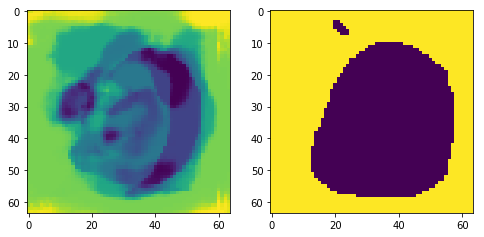

ICL_A27 CT S4-centroid


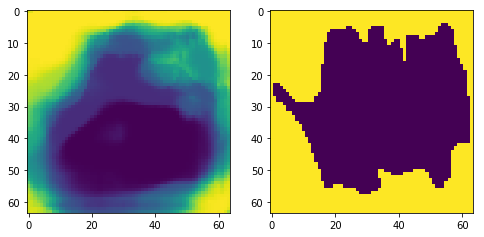

AstraZeneca_CT26_xenograft


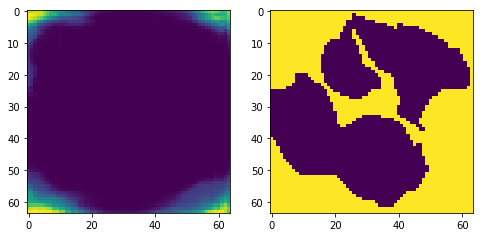

In [366]:
test_gen = batch_generator_factory.test_generator(test_ds_names, test=True)

for ds_name, img_batch, mask in test_gen:
    print(ds_name)
    pred_batch = model.predict(img_batch, batch_size=img_batch.shape[0])
    pred_img = pred_batch.mean(axis=0)[:,:,0]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.imshow(pred_img)
    ax2.imshow(mask)
    plt.show()

adrenal gland neg


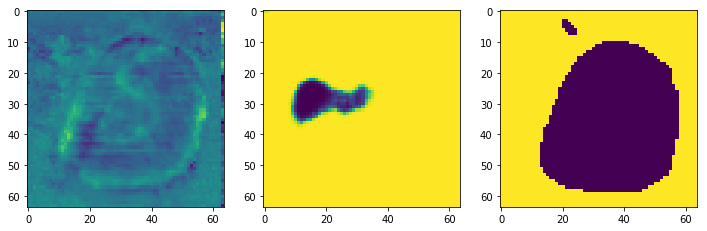

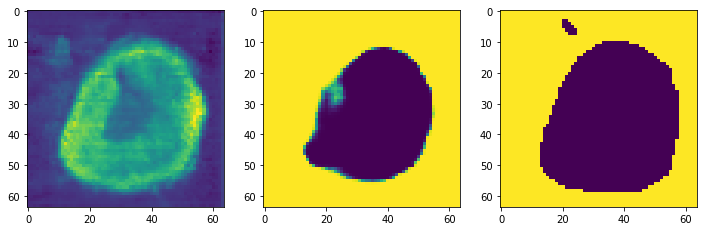

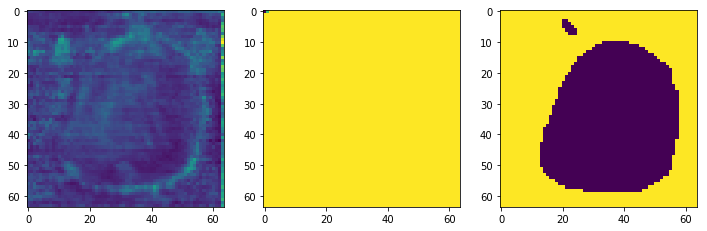

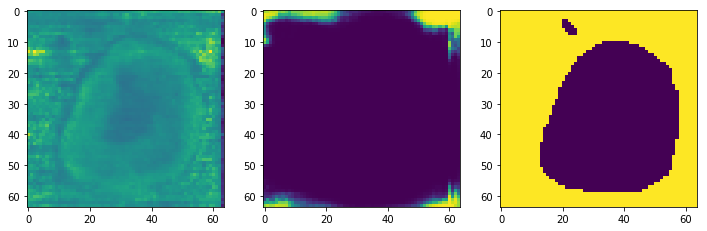

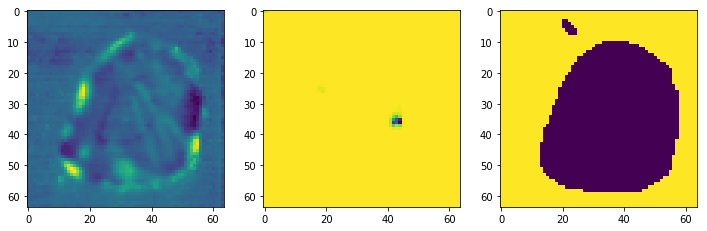

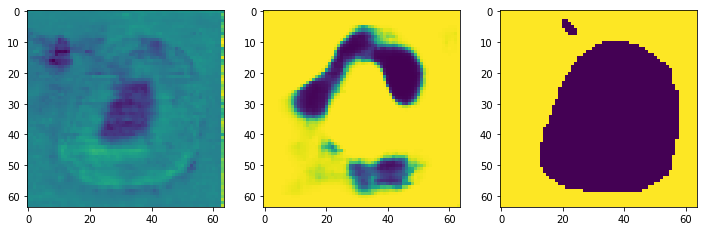

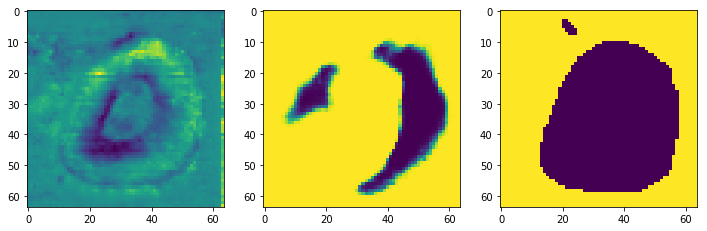

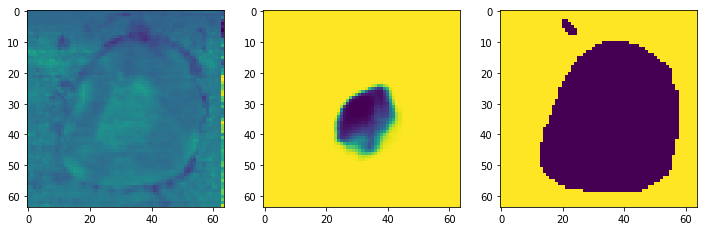

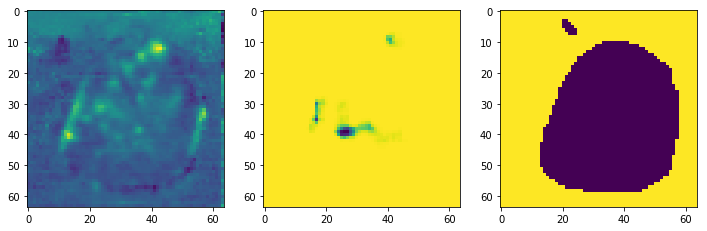

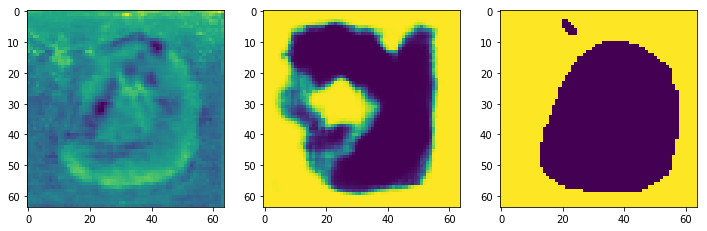

ICL_A27 CT S4-centroid


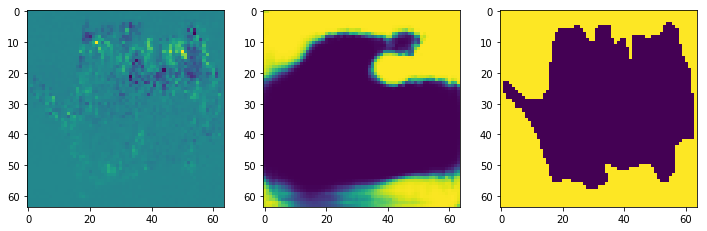

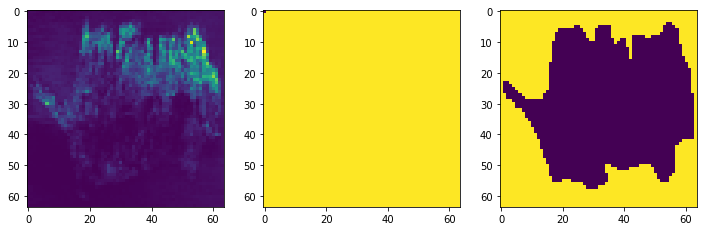

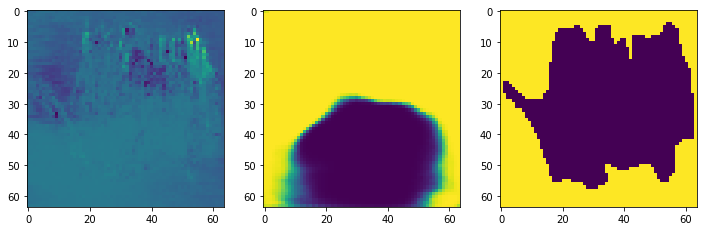

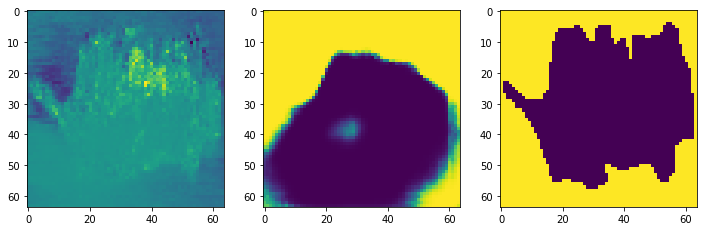

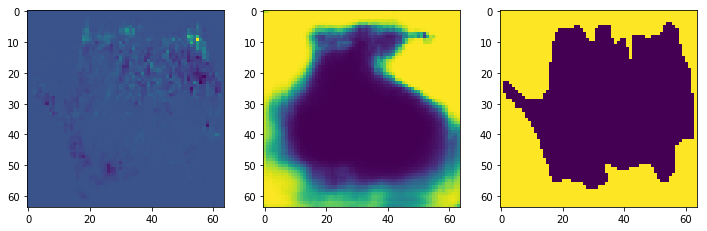

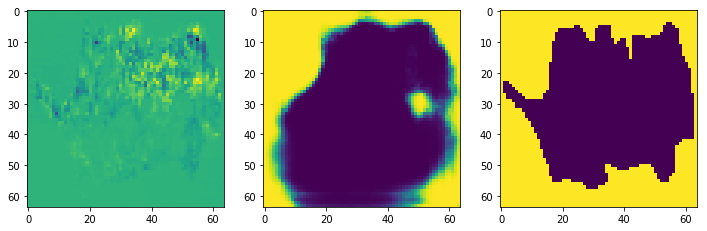

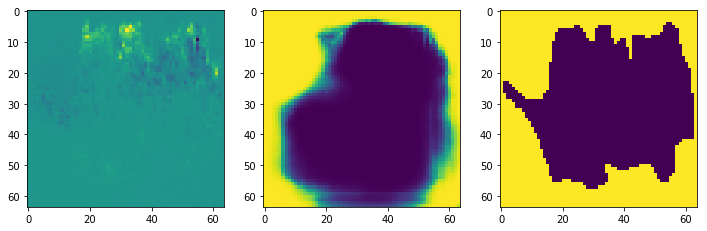

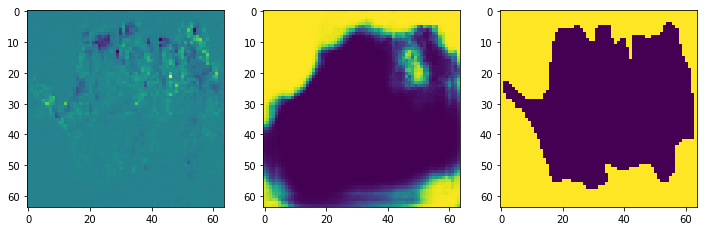

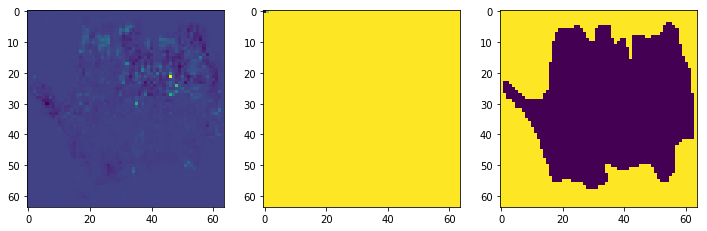

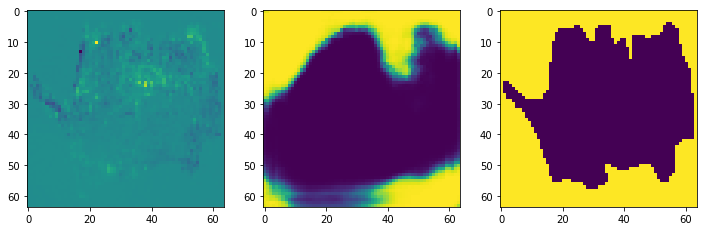

AstraZeneca_CT26_xenograft


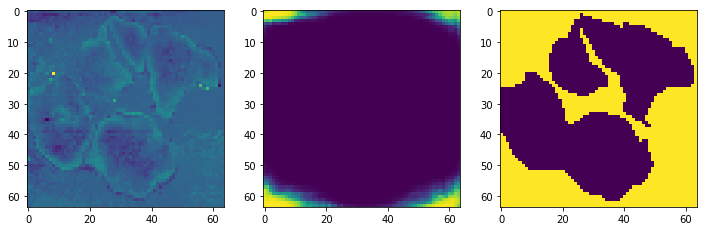

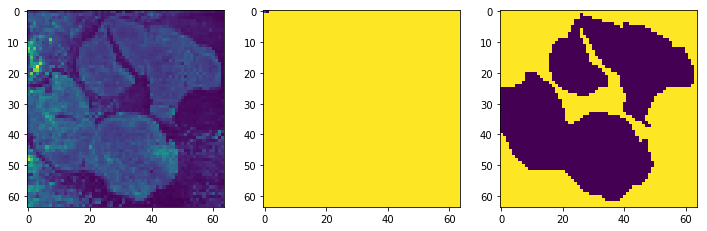

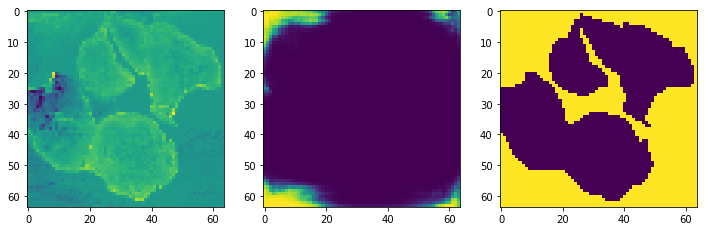

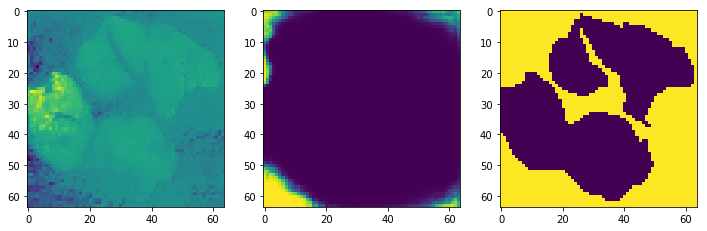

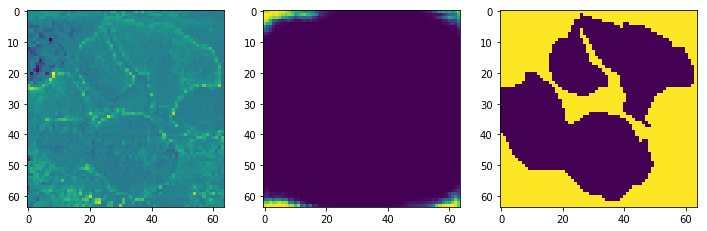

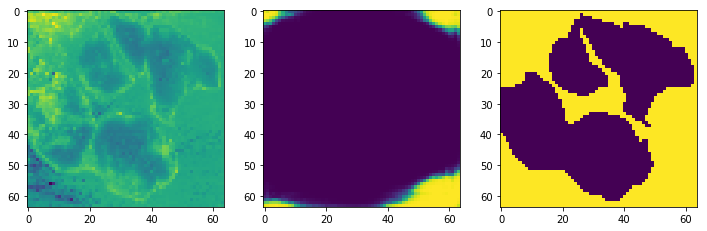

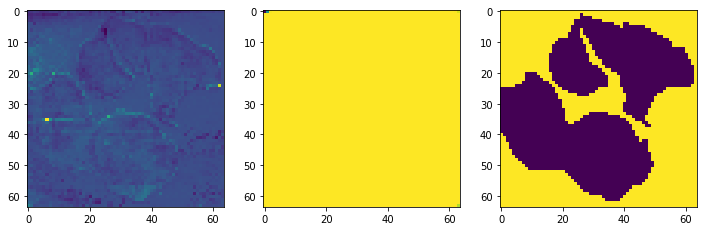

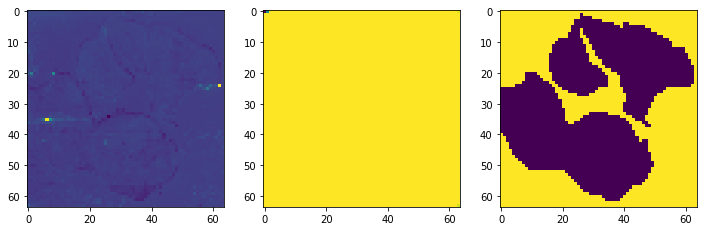

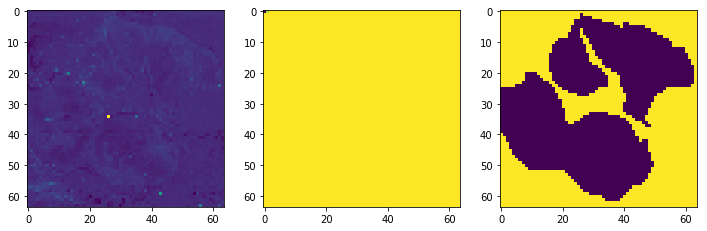

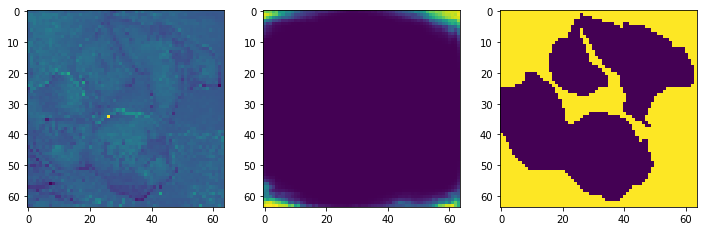

In [367]:
# test_gen = batch_generator('data/pca_data', ds_names=test_ds_names, batch_size=1, aug_dict=data_gen_args)
# test_gen = batch_generator_factory.generator(test_ds_names, batch_size=1, test=True,
#                                              aug_dict=data_gen_args)
test_gen = batch_generator_factory.test_generator(test_ds_names, test=True)

for ds_name, img_batch, mask in test_gen:
    print(ds_name)
    pred_batch = model.predict(img_batch, batch_size=img_batch.shape[0])
 
    for i in range(img_batch.shape[0]):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
        img = img_batch[i,:,:,0]
        pred = pred_batch[i,:,:,0]
        ax1.imshow(img)
        ax2.imshow(pred)
        ax3.imshow(mask)
        plt.show()

___

In [ ]:
# test_gen = test_generator('data/ion_images/test/image/1000155A4+',
#                           num_image=100, target_size=(image_hw, image_hw))
# # results = model.predict_generator((img for img in images), steps=30, verbose=1)
# results = [model.predict(batch, batch_size=1, verbose=0)[0,:,:,0]
#            for batch in test_gen]
# test_pred_path = Path('data/ion_images/test/pred/1000155A4+')
# test_pred_path.mkdir(parents=True, exist_ok=True)
# save_result(test_pred_path, results)

In [ ]:
from imageio import imread

In [ ]:
test_label_path_gen = Path('data/ion_images/test/label/1000155A4+').iterdir()
label_path = next(test_label_path_gen)

In [ ]:
plt.imshow(imread(label_path))

In [ ]:
test_image_path_gen = Path('data/ion_images/test/image/1000155A4+').iterdir()
# test_pred_path_gen = Path('data/ion_images/test/pred/1000155A4+').iterdir()

for i in range(10):
    img_path = next(test_image_path_gen)
    img = imread(img_path)
    img = img / img.max()
    
    pred_img = model.predict(np.reshape(img, (1,) + img.shape + (1,)), batch_size=1)
    
    print(img_path)
    plt.imshow(img)
    plt.show()
    plt.imshow(pred_img.squeeze())
    plt.show()